In [0]:
'''
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
'''

"\n# mounts Google Drive to the Colab VM\nfrom google.colab import drive, files\ndrive.mount('/content/drive', force_remount=True)\n\n# project github foldername\nFOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'\n\n# load python files from foldername\nimport sys\nsys.path.append(FOLDERNAME)\n\n# for auto-reloading external modules\n%load_ext autoreload\n%autoreload 2\n"

In [1]:
# Useful libraries
import numpy as np
import math as ma
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from google.colab import files
import csv
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

# Custom metrics
def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)
def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)
def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

--2020-05-30 22:50:12--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781.25M  29.4MB/s    in 27s     

2020-05-30 22:50:40 (28.6 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]



In [0]:
#
# Parameters
#
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.RMSprop()
nk = 64
ks = 5
lks = 1
#
Ninput = 10
Noutput = 5
#
Nsample = 100
bs = 10
ep = 4

In [0]:
#
# Data processing
#
def preprocess(data):
  data = data/255.
  data = data.swapaxes(0, 1)
  data = np.expand_dims(data, -1)
  return data
def split_train_test(dataset, n):
  data = np.load(dataset, mmap_mode='r')
  train = data[:, :n, :, :]
  test = data[:, n:n+n//10, :, :]
  train = preprocess(train)
  test = preprocess(test)
  return train, test
def make_XY(data, Ninput, Noutput):
  X = data[:, :Ninput, :, :, :]
  y = data[:, Ninput:Ninput+Noutput, :, :, :]
  return X, y
data_train, data_test = split_train_test('mnist_test_seq.npy', Nsample)
H, W, C = data_train.shape[-3:]
X, y = make_XY(data_train, Ninput, Noutput)
Xtest, ytest = make_XY(data_test, Ninput, Noutput)

In [0]:
# Model Architecture
def model_init():
  inputs = tf.keras.Input(shape=[None, H, W, C])
  # Encoder
  CL1, cl1_h, cl1_c = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                                 return_sequences=True, return_state=True)(inputs)
  CL2, cl2_h, cl2_c = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                                 return_state=True)(CL1)
  # Decoder 1
  CL3 = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                   return_sequences=True)(tf.zeros([Noutput, H, W, nk])[None, :, :, :, :],
                                                          initial_state=[cl1_h, cl1_c])
  CL4 = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                   return_sequences=True)(CL3, initial_state=[cl2_h, cl2_c])
  # Prediction
  concat = tf.keras.layers.Concatenate()([CL3, CL4])
  preds = tf.keras.layers.Conv3D(1, lks, padding='same',
                                 activation='sigmoid')(concat)
  return tf.keras.Model(inputs=inputs, outputs=preds)

In [6]:
# Initialize model
model = model_init()

# Build optimizer
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['acc', ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall')])

# Fit the model
history = model.fit(X, y, 
                    batch_size=bs, 
                    epochs=ep,
                    validation_split=0.1)

# Get results on test set
results = model.evaluate(Xtest, ytest, batch_size=bs, return_dict=True)

Epoch 1/4
9/9 [==============================] - 7s 827ms/step - loss: 0.2783 - acc: 0.8948 - ssim: 0.0464 - psnr: 12.6352 - cor: 0.0479 - prec: 0.1100 - recall: 0.0577 - val_loss: 0.1977 - val_acc: 0.9267 - val_ssim: 0.0470 - val_psnr: 13.8838 - val_cor: 0.2005 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/4
9/9 [==============================] - 6s 639ms/step - loss: 0.1961 - acc: 0.9283 - ssim: 0.0370 - psnr: 14.0505 - cor: 0.1376 - prec: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1937 - val_acc: 0.9267 - val_ssim: 0.0306 - val_psnr: 13.9258 - val_cor: 0.2090 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/4
9/9 [==============================] - 6s 639ms/step - loss: 0.1936 - acc: 0.9283 - ssim: 0.0338 - psnr: 14.0730 - cor: 0.1410 - prec: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1895 - val_acc: 0.9267 - val_ssim: 0.0311 - val_psnr: 13.9645 - val_cor: 0.2099 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/4
1/1 [==============================] - 0s

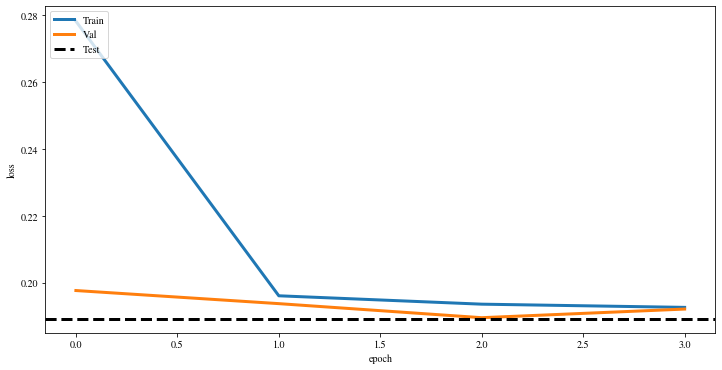

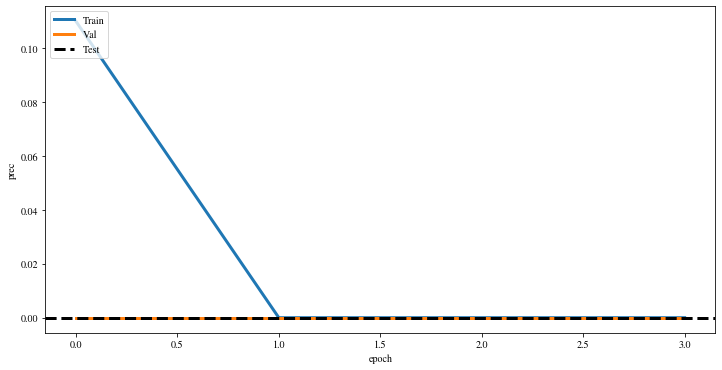

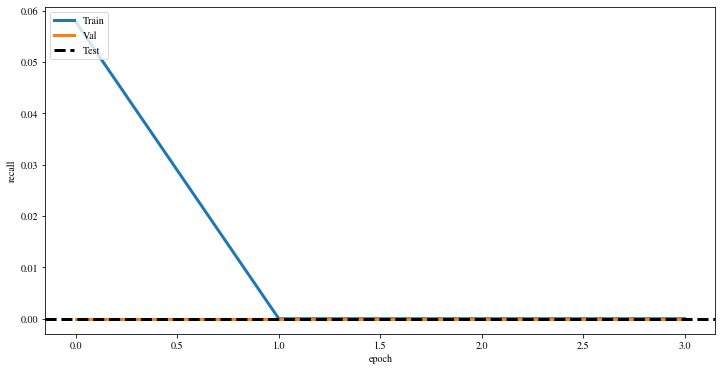

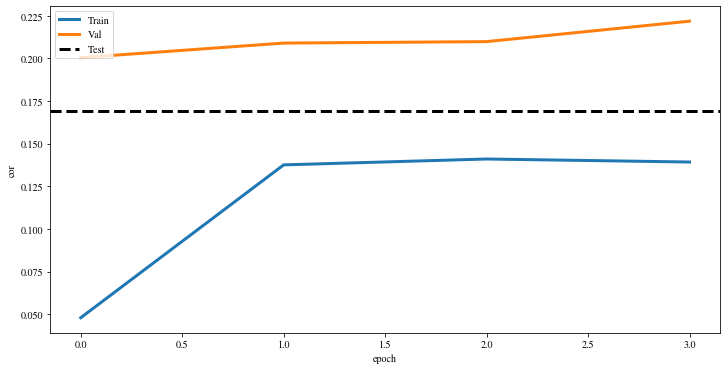

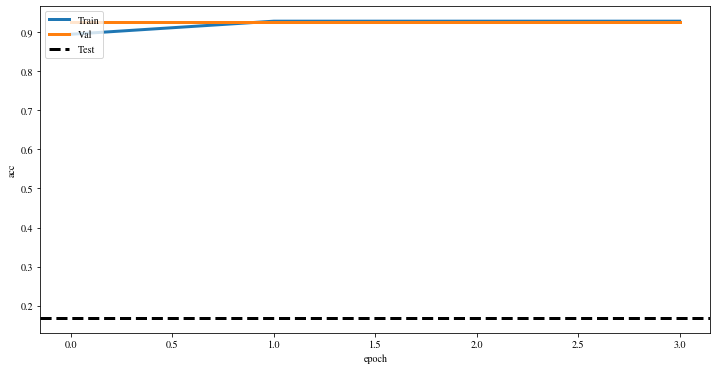

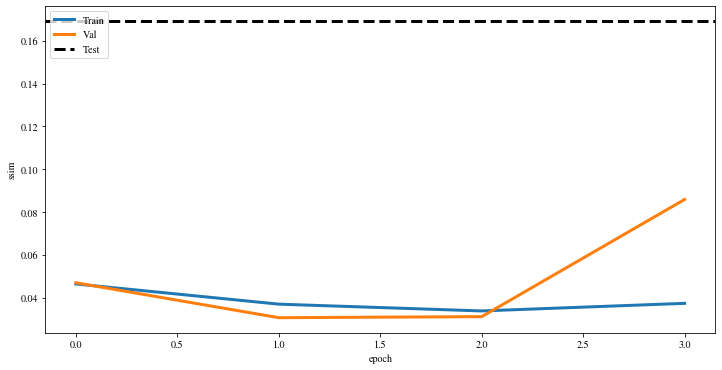

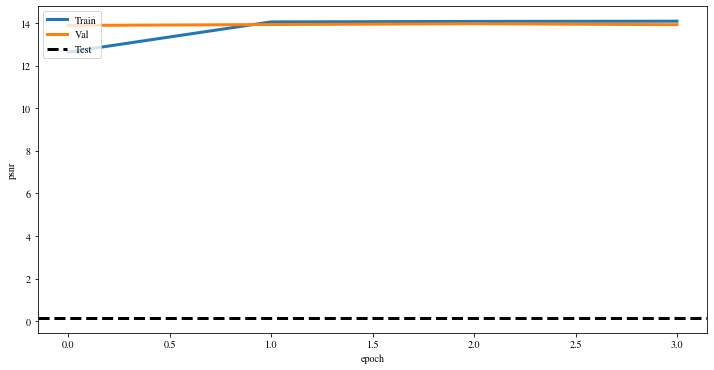

In [7]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.axhline(results['loss'], linestyle='--', color='k', label='Test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss.png')
#files.download('loss.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['prec'], label='Train')
plt.plot(history.history['val_prec'], label='Val')
plt.axhline(results['prec'], linestyle='--', color='k', label='Test')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('prec.png')
#files.download('prec.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.axhline(results['recall'], linestyle='--', color='k', label='Test')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('recall.png')
#files.download('recall.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('cor')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('cor.png')
#files.download('cor.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('acc.png')
#files.download('acc.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('ssim.png')
#files.download('ssim.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('psnr.png')
#files.download('psnr.png')

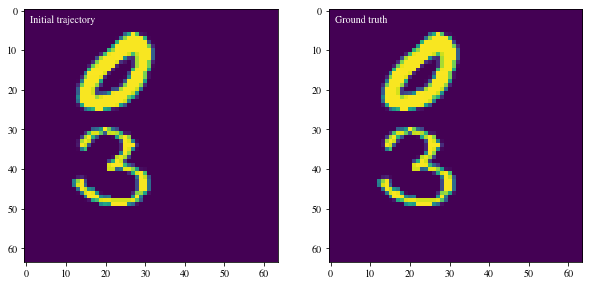

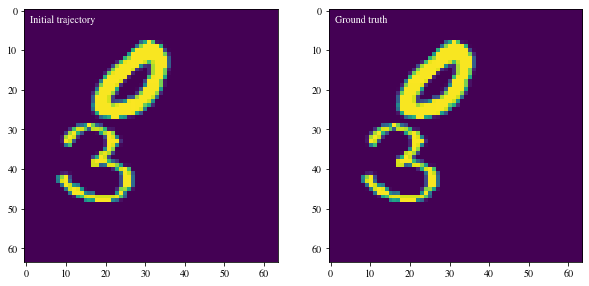

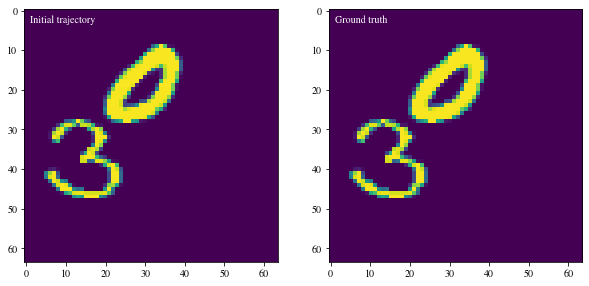

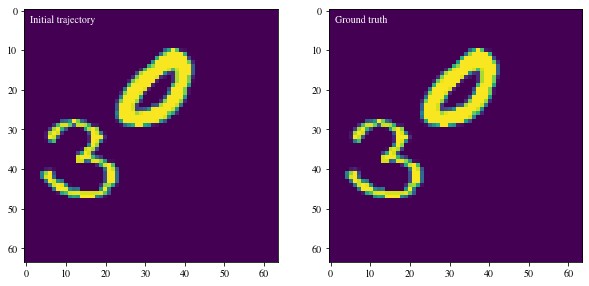

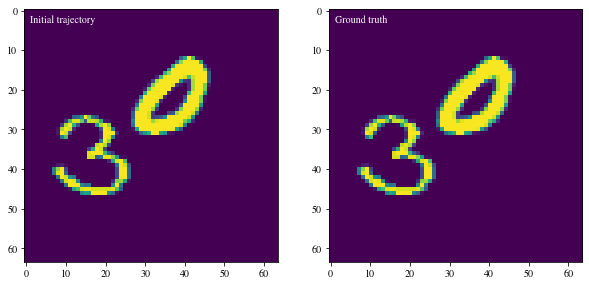

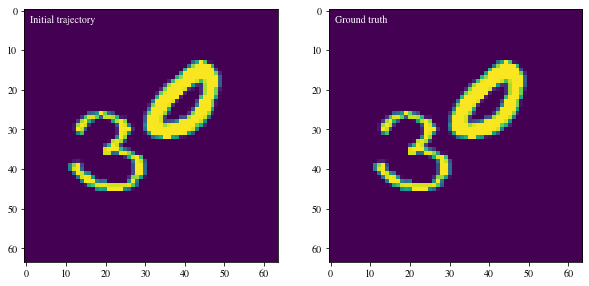

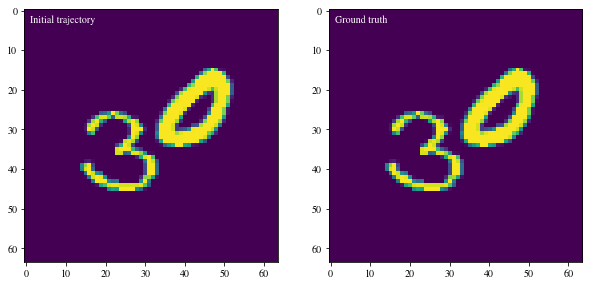

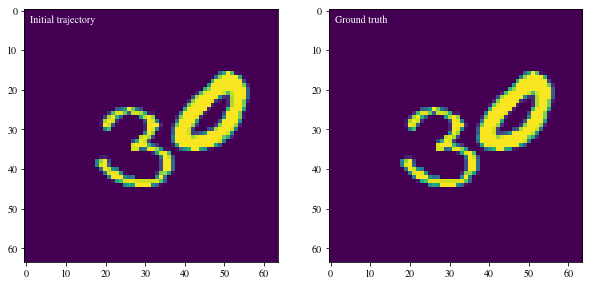

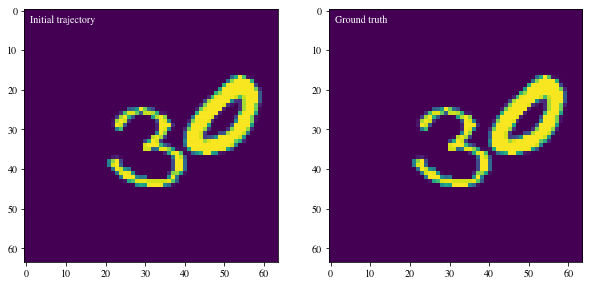

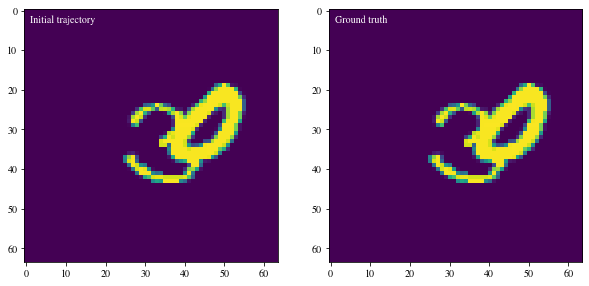

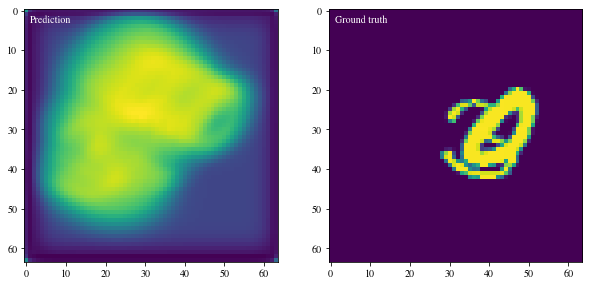

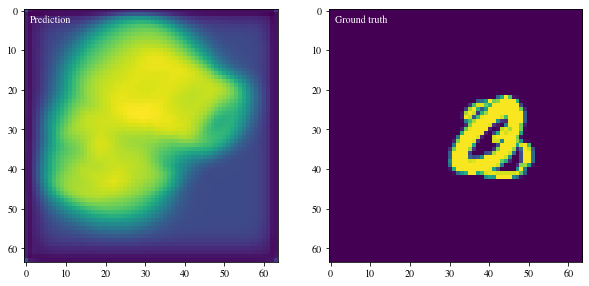

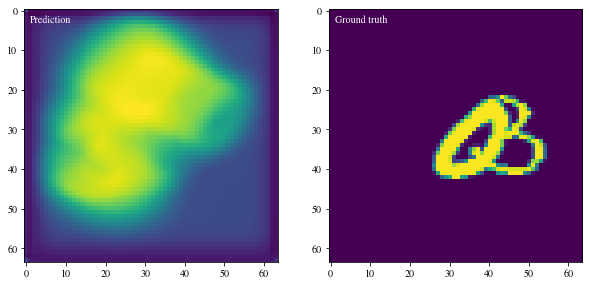

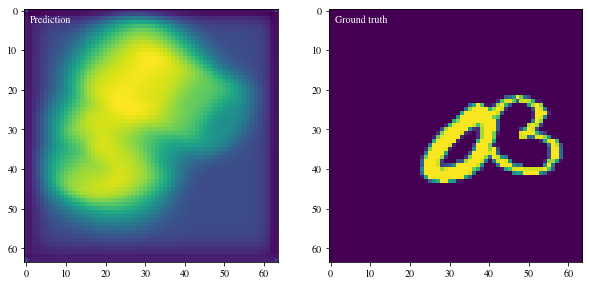

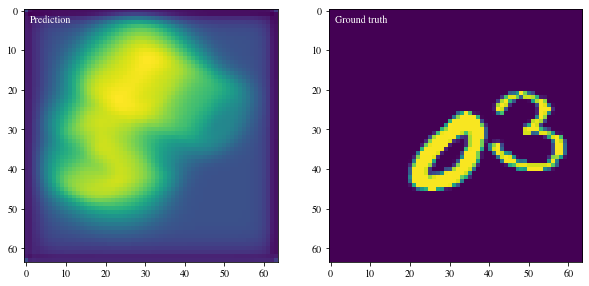

In [8]:
# Plot Train
itest = 1
track = X[itest, :, :, :, :]
track = np.concatenate((track[None,:,:,:,:], model.predict(track[None,:,:,:,:])), axis=1)
true_track = data_train[itest, :, :, :, :]
for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[0, i, :, :, 0])
    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])
    plt.savefig('train_%i.png' % (i+1))
    #files.download('train_%i.png' % (i+1))

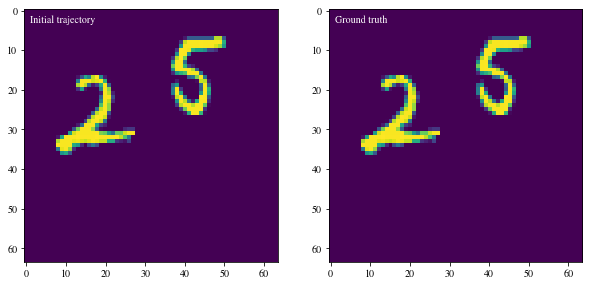

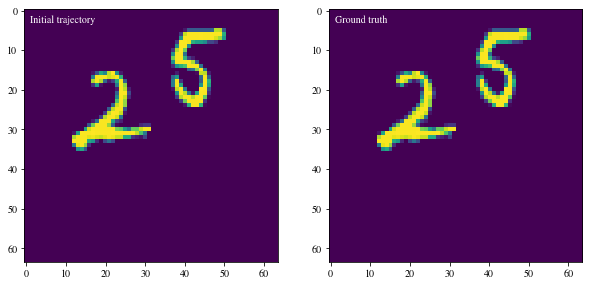

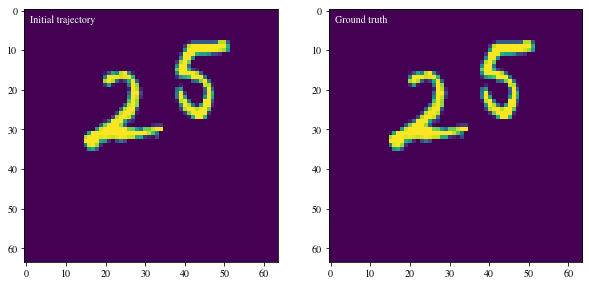

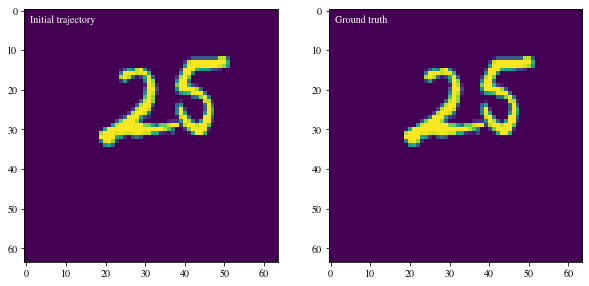

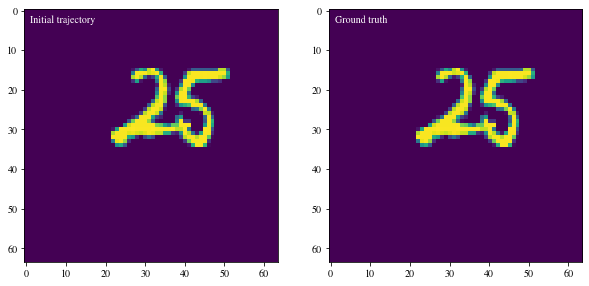

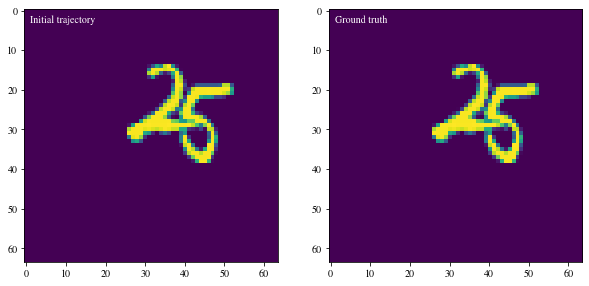

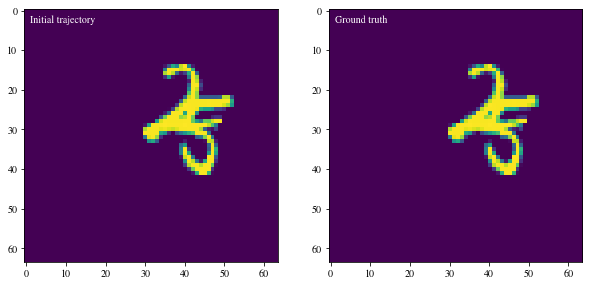

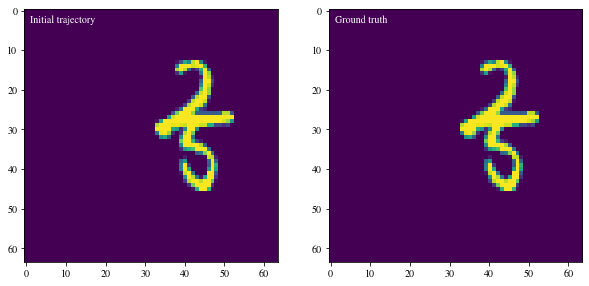

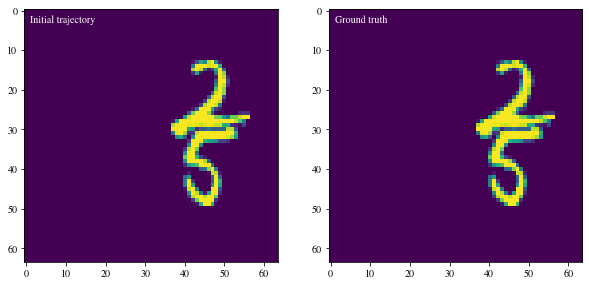

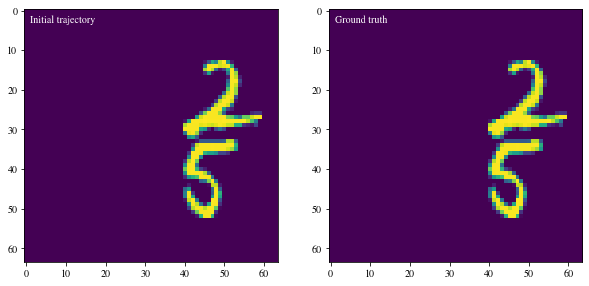

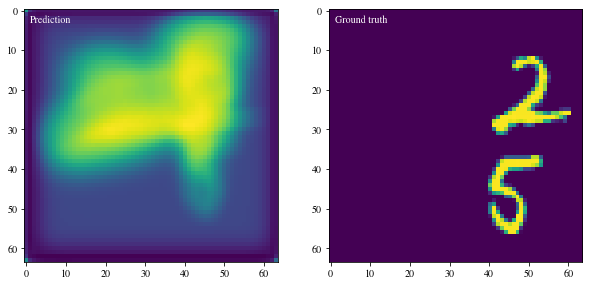

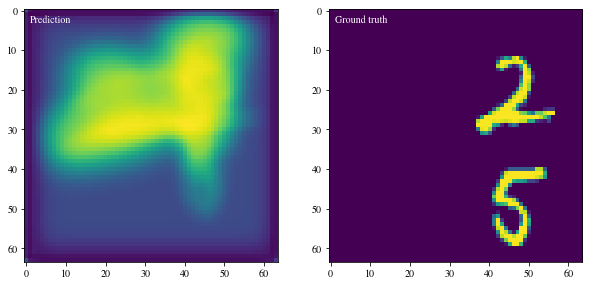

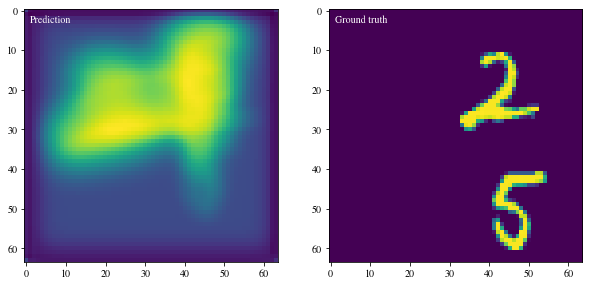

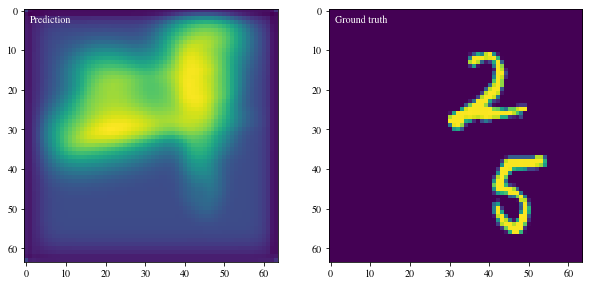

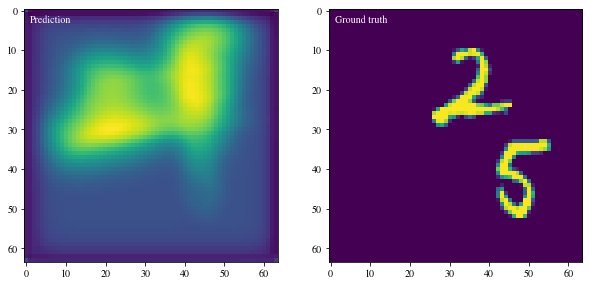

In [9]:
# Plot Test
itest = 1
track = Xtest[itest, :, :, :, :]
track = np.concatenate((track[None,:,:,:,:], model.predict(track[None,:,:,:,:])), axis=1)
true_track = data_test[itest, :, :, :, :]
for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[0, i, :, :, 0])
    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])
    plt.savefig('test_%i.png' % (i+1))
    #files.download('test_%i.png' % (i+1))